## Импорт библиотек

In [43]:
# Данные
import numpy as np
import pandas as pd
# Визуализация
import matplotlib.pyplot as plt
# Файловая система
import gdown
from pathlib import Path
from collections import Counter
# Генератор
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
# Сеть
import tensorflow as tf

In [ ]:
# Для визуализации изменений метрик в ходе обучения можно добавить колбэк
if False:
  ! pip install livelossplot
  from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface .

Скчать саму модель можно по ссылке: https://drive.google.com/open?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO 

In [4]:
vggface_model = tf.keras.models.load_model("/content/drive/MyDrive/Face_model/resnet50face.h5")

Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем мы заморозим большую часть этой сети и будем рабоать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

In [11]:
vggface_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

## Загрузка данных


In [12]:
! tar -xzf /content/drive/MyDrive/Face_model/UTKFace.tar.gz -C /tmp/

In [17]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print('Найденно:', len(filenames), 'изображений')

Найденно: 23708 изображений


In [29]:
image_coder = filenames[:1][0].split('_')
print('Наименование файла', filenames[:1][0])
print(f'Где:\nвозраст: {image_coder[0]}  индекс пола: {image_coder[1]}  индекс рассы: {image_coder[2]}')

Наименование файла 46_1_1_20170116223430582.jpg.chip.jpg
Где:
возраст: 46  индекс пола: 1  индекс рассы: 1


In [30]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg


,img_name,age,race,gender
0,4_0_0_20170110213307248.jpg.chip.jpg,0.034483,0,0
1,1_0_0_20170110213005631.jpg.chip.jpg,0.008621,0,0
2,1_0_0_20170109193823674.jpg.chip.jpg,0.008621,0,0
3,1_0_2_20161219160747326.jpg.chip.jpg,0.008621,2,0
4,24_1_0_20170117150858676.jpg.chip.jpg,0.206897,0,1


In [32]:
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 129MB/s]


'train_val_split_utk.csv'

In [33]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [34]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

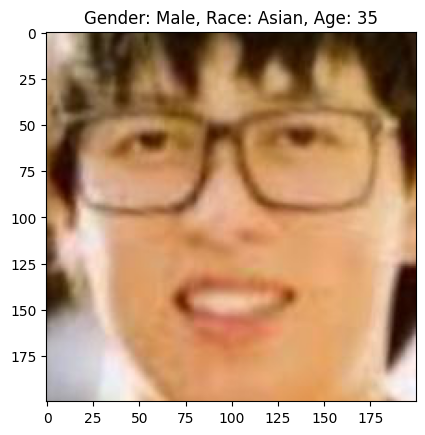

In [35]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


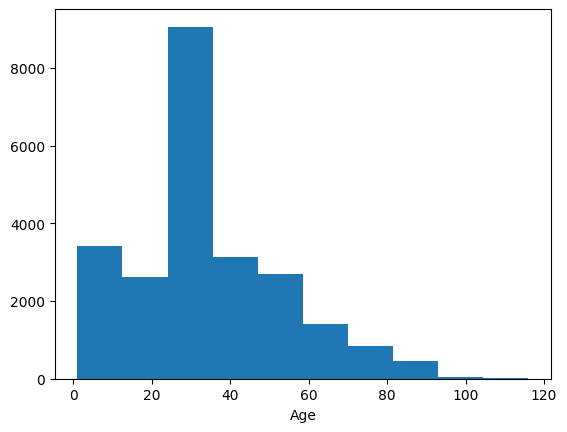

In [36]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

##Создание генератора данных для модели предсказания пола.

In [44]:
# Функция препроцессинга необходимоя для модели VGGFace2
def preprocess_input_facenet(image_):
  img = np.copy(image_)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img[..., :: - 1]
  img[..., 0] -= 91.4953
  img[..., 1] -= 103.8827
  img[..., 2] -= 131.0912
  return img

image_gen = ImageDataGenerator(preprocessing_function = preprocess_input_facenet)

In [46]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(df_train, directory = str(data_folder), batch_size = BATCH_SIZE, target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                                x_col = 'img_name', y_col = 'gender', class_mode = 'binary', shuffle = True)

val_generator = image_gen.flow_from_dataframe(df_val, directory = str(data_folder), batch_size = BATCH_SIZE, target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                              x_col = 'img_name', y_col = 'gender', class_mode = 'binary', shuffle = False)

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Female


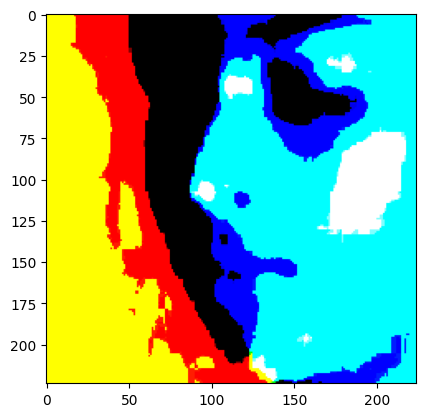

In [50]:
sample_images, sample_labels = next(val_generator)

plt.imshow(sample_images[0])
print(gender_mapping[int(sample_labels[0])])

Female


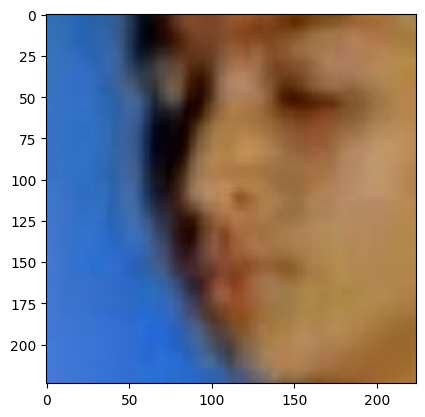

In [51]:
# Функция депроцессинга изображений
def deprocess_image(vggface_image):

  image_ = vggface_image.copy()
  image_ = image_[:, :, ::-1]
  image_[:, :, 2] += 91.4953
  image_[:, :, 1] += 103.8827
  image_[:, :, 0] += 131.0912
  return np.uint8(image_)


# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[0]))
print(gender_mapping[int(sample_labels[0])])

##Обучение модели предсказания пола



In [ ]:
# Создадим чекпоит для сохранения лучшей модели
filename = 'gender_model.h5'
path = Path('/content/best_model/' + filename)
checkpoint = tf.keras.callbacks.ModelCheckpoint(path, verbose = 1, monitor = 'val_accuracy', mode = 'max', save_best_only = True)

In [ ]:
# для начала отрежем от vggface_model последний слой классификатора 
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)

# Заморозим модель
base_model.trainable = False

In [ ]:
# Добавим для нашей задачи два полносвязных слоя
gen_model = tf.keras.Sequential([base_model, 
                                 tf.keras.layers.Dense(128, activation = 'relu'),
                                 tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Output_1_cat')])

gen_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 Output_1_cat (Dense)        (None, 1)                 129       
                                                                 
Total params: 23,823,553
Trainable params: 262,401
Non-trainable params: 23,561,152
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Запустим обучение
history = gen_model.fit_generator(train_generator, validation_data = val_generator, verbose = 1, epochs = 20, steps_per_epoch = 50, callbacks = [checkpoint])

Epoch 1/20


<ipython-input-51-fc6e9b7233f5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = gen_model.fit_generator(train_generator, validation_data = val_generator, verbose = 1, epochs = 20, steps_per_epoch = 50, callbacks = [checkpoint])#, PlotLossesCallback()])


50/50 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.8556
Epoch 1: val_accuracy improved from -inf to 0.92015, saving model to /content/drive/MyDrive/Face_model/best_model/gender_model.h5
50/50 [==============================] - 22s 390ms/step - loss: 0.4848 - accuracy: 0.8556 - val_loss: 0.2138 - val_accuracy: 0.9202
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9169
Epoch 2: val_accuracy improved from 0.92015 to 0.92141, saving model to /content/drive/MyDrive/Face_model/best_model/gender_model.h5
50/50 [==============================] - 20s 399ms/step - loss: 0.2254 - accuracy: 0.9169 - val_loss: 0.1978 - val_accuracy: 0.9214
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9319
Epoch 3: val_accuracy improved from 0.92141 to 0.92351, saving model to /content/drive/MyDrive/Face_model/best_model/gender_model.h5
50/50 [==============================] - 20s 395ms/step - loss: 0.195

In [ ]:
# Выгрузим лучшую модель и проверим метрику
model_gender = tf.keras.models.load_model("/conten/best_model/gender_model.h5")
loss, acc = model_gender.evaluate(val_generator)

149/149 [==============================] - 21s 126ms/step - loss: 0.1618 - accuracy: 0.9420
Well done!


In [ ]:
#@title (вспомогательный код, выполните клетку)
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

1/1 [==============================] - 1s 653ms/step


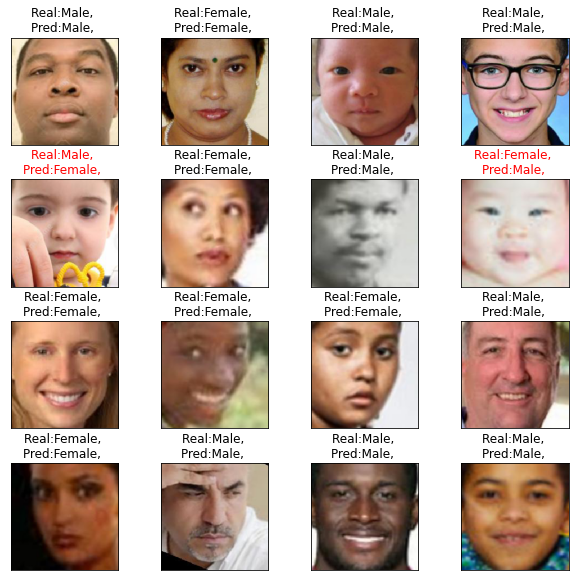

In [ ]:
# Посмотрим на результат
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

##Обучение модели предсказания расы


In [ ]:
# Создадим новый генератор для предсказания рассы
train_generator = image_gen.flow_from_dataframe(df_train, directory = str(data_folder), batch_size = BATCH_SIZE, target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                                x_col = 'img_name', y_col = 'race', class_mode = 'sparse', shuffle = True)

val_generator = image_gen.flow_from_dataframe(df_val, directory = str(data_folder), batch_size = BATCH_SIZE, target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                              x_col = 'img_name', y_col = 'race', class_mode = 'sparse', shuffle = False)

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [ ]:
# Выгрузим модель
vggface_model = tf.keras.models.load_model("/content/drive/MyDrive/Face_model/resnet50face.h5")
# оУберем последний слой
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
# Заморозим модель
base_model.trainable = False

In [ ]:
# Создадим чекпоинт
filename = 'pace_model.h5'
path = Path('/content/best_model/' + filename)
checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
# Добавим полносвязных слоев для классификации
model = tf.keras.Sequential([base_model, 
                             tf.keras.layers.Dense(128, activation = 'relu', name = 'Train_Layer1'),
                             tf.keras.layers.Dense(128, activation = 'relu', name = 'Train_Layer2'),
                             tf.keras.layers.Dense(5, activation = 'sigmoid', name = 'Output_Layer')])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 2048)              23561152  
                                                                 
 Train_Layer1 (Dense)        (None, 128)               262272    
                                                                 
 Train_Layer2 (Dense)        (None, 128)               16512     
                                                                 
 Output_Layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 23,840,581
Trainable params: 279,429
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
# Запустим обучение
history = model.fit_generator(train_generator, validation_data = val_generator, verbose = 1, epochs = 13, steps_per_epoch = 50, callbacks = [checkpoint])#, PlotLossesCallback()])

Epoch 1/13


<ipython-input-68-1c4edf2751dc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = val_generator, verbose = 1, epochs = 13, steps_per_epoch = 50, callbacks = [checkpoint])#, PlotLossesCallback()])


50/50 [==============================] - ETA: 0s - loss: 0.7764 - accuracy: 0.7625
Epoch 1: val_accuracy did not improve from 0.87476
50/50 [==============================] - 79s 2s/step - loss: 0.7764 - accuracy: 0.7625 - val_loss: 0.5078 - val_accuracy: 0.8458
Epoch 2/13
50/50 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.8656
Epoch 2: val_accuracy did not improve from 0.87476
50/50 [==============================] - 19s 387ms/step - loss: 0.4554 - accuracy: 0.8656 - val_loss: 0.4645 - val_accuracy: 0.8592
Epoch 3/13
50/50 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.8544
Epoch 3: val_accuracy did not improve from 0.87476
50/50 [==============================] - 20s 406ms/step - loss: 0.4409 - accuracy: 0.8544 - val_loss: 0.4872 - val_accuracy: 0.8533
Epoch 4/13
50/50 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.8506
Epoch 4: val_accuracy did not improve from 0.87476
50/50 [==============================]

In [ ]:
# проверим метрики лучшей модели
model_race = tf.keras.models.load_model("/content/best_model/pace_model.h5")
loss, acc = model_race.evaluate(val_generator)

149/149 [==============================] - 16s 104ms/step - loss: 0.4211 - accuracy: 0.8777
Well done!


1/1 [==============================] - 0s 33ms/step


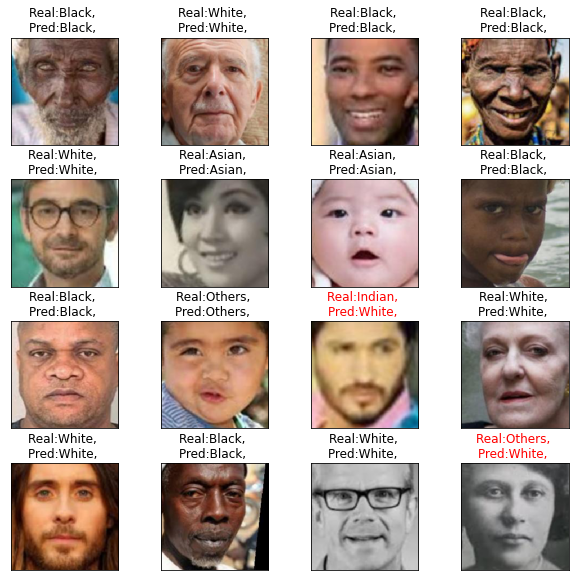

In [ ]:
# Посмотрим на результат
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

##Multitask learning

Если на каждый атрибут (возраст, раса, пол) создавать одну модель, то таких моделей получится 3. Очевидно, что для предсказания на новой картике необходимо будет произвести инференс трех сетей. Это может быть ресурсо-затратно и сложнее в поддержке. 

Какой же есть еще подход? Он называется Multitask learning. Его идея в том, чтобы обучать одну модель для решения сразу нескольких задач! Гибкость нейронных сетей позволяет это сделать достаточно логичными образом. Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом в нашей задаче одна будет отвечать за классификацию пола (1 выход, вероятность), вторая -- за классификацию расы (5 выходов, вероятности) и третья -- за предсказания возраста (1 выход, число).

In [ ]:
vggface_model = tf.keras.models.load_model("/content/drive/MyDrive/Face_model/resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

In [ ]:
# Создадим генератор для нашей супер-пупер модели
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1].astype(np.float32), 3, axis=1)
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


In [ ]:
# Создадим архитектуру модели
input_layer = tf.keras.layers.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name = 'Input_Layer')

base_model_layer = base_model(input_layer)

gender_train = tf.keras.layers.Dense(128, activation = 'relu', name = 'gender_train')(base_model_layer)
gender = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'gender')(gender_train)

race_train = tf.keras.layers.Dense(128, activation = 'relu', name = 'racer_train')(base_model_layer)
race = tf.keras.layers.Dense(5, activation = 'sigmoid', name = 'race')(race_train)

age_train = tf.keras.layers.Dense(128, activation = 'relu', name = 'age_train')(base_model_layer)
age_train2 = tf.keras.layers.Dense(128, activation = 'relu', name = 'age_train2')(age_train)
age = tf.keras.layers.Dense(1, name = 'age')(age_train)

model = tf.keras.Model(inputs=input_layer, outputs=[gender, race, age])

#model.summary()
#tf.keras.utils.plot_model(model)

А теперь перейдем к обучению:

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # вы можете выбрать другую скорость обучения для вашей модели

# обратите внимание, что теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics

metric_race = tf.keras.metrics.SparseCategoricalAccuracy()
model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': metric_race, 'age': 'mae'})


filename = "multitask_model.h5"
path = ('/content/best_model/' + filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min')

model.fit_generator(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator), callbacks=[checkpoint], steps_per_epoch=50, 
                                                                                                  validation_steps= len(df_val) // BATCH_SIZE)

Epoch 1/15


<ipython-input-66-784c95b87679>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator), callbacks=[checkpoint], steps_per_epoch=50,


50/50 [==============================] - ETA: 0s - loss: 5.4910 - gender_loss: 0.5198 - race_loss: 1.0853 - age_loss: 3.8859 - gender_accuracy: 0.8300 - race_sparse_categorical_accuracy: 0.7444 - age_mae: 1.1730
Epoch 1: val_age_mae improved from inf to 0.32392, saving model to /content/best_model/multitask_model.h5
50/50 [==============================] - 23s 402ms/step - loss: 5.4910 - gender_loss: 0.5198 - race_loss: 1.0853 - age_loss: 3.8859 - gender_accuracy: 0.8300 - race_sparse_categorical_accuracy: 0.7444 - age_mae: 1.1730 - val_loss: 0.9340 - val_gender_loss: 0.2111 - val_race_loss: 0.5411 - val_age_loss: 0.1818 - val_gender_accuracy: 0.9154 - val_race_sparse_categorical_accuracy: 0.8386 - val_age_mae: 0.3239
Epoch 2/15
50/50 [==============================] - ETA: 0s - loss: 0.8337 - gender_loss: 0.2443 - race_loss: 0.4775 - age_loss: 0.1119 - gender_accuracy: 0.9156 - race_sparse_categorical_accuracy: 0.8581 - age_mae: 0.2548
Epoch 2: val_age_mae improved from 0.32392 to 0.2

In [ ]:
model_multitask = tf.keras.models.load_model("/content/best_model/multitask_model.h5")
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)

Found 4759 validated image filenames.


In [ ]:
# Проверм метрики
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

148/148 [==============================] - 14s 94ms/step - loss: 0.5485 - gender_loss: 0.1511 - race_loss: 0.3905 - age_loss: 0.0069 - gender_accuracy: 0.9424 - race_sparse_categorical_accuracy: 0.8796 - age_mae: 0.0600
Well done!


1/1 [==============================] - 1s 732ms/step


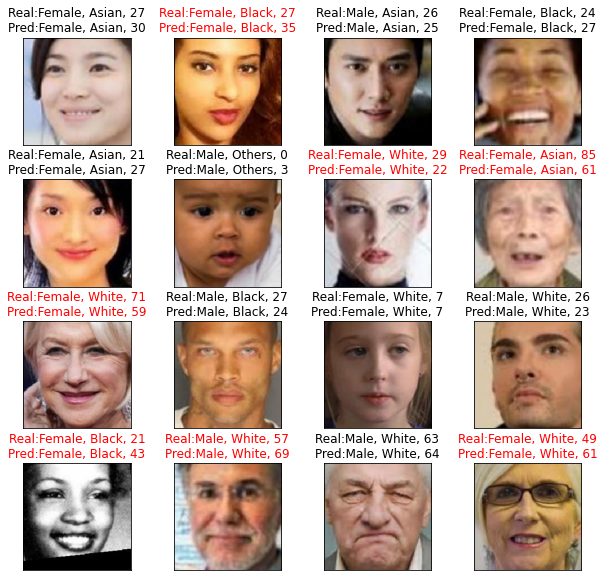

In [ ]:
# Проверим результат
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )